In [1]:
import json
import os
import argparse

import numpy as np
import random
import torch
from torch import nn, optim
from tqdm.auto import tqdm
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from torch.utils.data import DataLoader, Subset
import sys
sys.path.append('../lib/exlib/src')
from exlib.modules.sop import SOPImageCls, SOPConfig, get_chained_attr

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

SEED = 42
if SEED != -1:
    # Torch RNG
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    # Python RNG
    np.random.seed(SEED)
    random.seed(SEED)

In [4]:
# model paths
backbone_model_name = 'google/vit-base-patch16-224'
# backbone_model_name = '../pt_models/vit-base-patch16-224-imagenet10cls'
backbone_processor_name = 'google/vit-base-patch16-224'
# sop_config_path = 'configs/imagenet_m.json'

# data paths
# TRAIN_DATA_DIR = '../data/imagenet_m/train'
# VAL_DATA_DIR = '../data/imagenet_m/val'
TRAIN_DATA_DIR = '../data/imagenet/train'
VAL_DATA_DIR = '../data/imagenet/val'
TRAIN_SEG_DIR = '/shared_data0/weiqiuy/github/ImageNet-S/datapreparation/ImageNetS919/train-semi-segmentation'
VAL_SEG_DIR = '/shared_data0/weiqiuy/github/ImageNet-S/datapreparation/ImageNetS919/validation-segmentation'

# training args
batch_size = 1
lr = 0.000005
num_epochs = 20
warmup_steps = 2000
mask_batch_size = 64

# experiment args
exp_dir = '../exps/imagenet_1h_lr8e-06_gg0.02_gs1.0_ggta1.0_ggtb0.1_ts-1_vs1_stcosine_ep0.5/best'

In [6]:
backbone_model = AutoModelForImageClassification.from_pretrained(backbone_model_name)
processor = AutoImageProcessor.from_pretrained(backbone_processor_name)
backbone_config = AutoConfig.from_pretrained(backbone_model_name)

config = SOPConfig()
config.update_from_json(os.path.join(exp_dir, 'config.json'))
config.__dict__

{'hidden_size': 768,
 'input_hidden_size': None,
 'num_labels': 1000,
 'projected_input_scale': 1,
 'num_heads': 1,
 'num_masks_sample': 20,
 'num_masks_max': 200,
 'image_size': 224,
 'num_channels': 3,
 'attn_patch_size': 16,
 'finetune_layers': ['model.classifier'],
 'group_gen_scale': 0.02,
 'group_gen_temp_alpha': 1.0,
 'group_gen_temp_beta': 0.1,
 'group_sel_scale': 1.0,
 'freeze_projection': False}

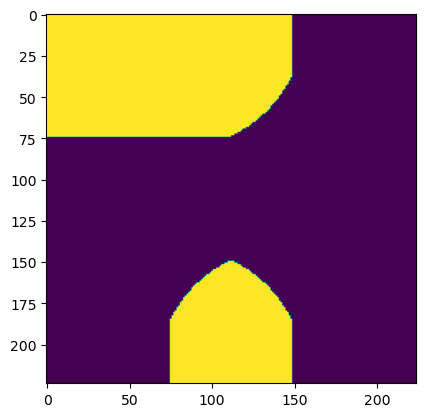

In [7]:
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

def resize_binary_image(image, size, mode='bilinear'):
    # Resize the image
    resized_image = F.interpolate(image, size=size, mode=mode, align_corners=False)

    # Threshold the image to convert values back to binary (0 or 1)
    thresholded_image = (resized_image > 0.5).float()

    return thresholded_image

# Example Usage
# Assuming 'binary_image' is a binary image tensor of shape (batch_size, channels, height, width)
# and you want to resize it to 128x128
binary_image = torch.tensor([[1,1,0],[0,0,0],[0,1,0]])[None,None].float()

resized_image = resize_binary_image(binary_image, size=(224, 224))
plt.imshow(resized_image[0][0])

In [8]:
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


class ImageFolderSegSubDataset(Dataset):
    def __init__(self, data_dir, seg_dir, transform=None, num_data=-1):
        self.data_dir = data_dir
        self.seg_dir = seg_dir
        self.transform = transform
        self.image_paths = []
        self.seg_paths = []
        self.labels = []
        self.all_labels = []
        
        for label in tqdm(sorted(os.listdir(data_dir))):
            seg_dirname = os.path.join(seg_dir, label)
            img_dirname = os.path.join(data_dir, label)
            if os.path.isdir(img_dirname):
                self.all_labels.append(label)
            if not os.path.isdir(seg_dirname):
                continue
            for i, seg_path in enumerate(sorted(os.listdir(os.path.join(seg_dir, label)))):
                if num_data != -1 and i >= num_data:
                    break
                image_path = seg_path.replace('.png', '.JPEG')
                if not os.path.exists(os.path.join(data_dir, label, image_path)):
                    continue
                self.image_paths.append(os.path.join(data_dir, label, image_path))
                self.seg_paths.append(os.path.join(seg_dir, label, seg_path))
                self.labels.append(label)
        print('Loaded {} images and {} classes'.format(len(self.image_paths), len(self.all_labels))) 
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.all_labels.index(self.labels[idx])
        seg_path = self.seg_paths[idx]
        image = Image.open(image_path)
        if self.transform is not None:
            image = self.transform(image)
        seg = Image.open(seg_path)
        seg = torch.tensor(np.asarray(seg))
        seg = seg.sum(-1)[None,None].float() # (bsz, num_channels, img_dim1, img_dim2)
        seg = resize_binary_image(seg, size=(image.shape[-2], image.shape[-1]))[0]
        return image, label, seg

In [9]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

def transform(image):
    # Preprocess the image using the ViTImageProcessor
    image = image.convert("RGB")
    inputs = processor(image, return_tensors='pt')
    return inputs['pixel_values'].squeeze(0)

# Load the dataset
# train_dataset = ImageFolder(root=TRAIN_DATA_DIR, transform=transform)
# val_dataset = ImageFolder(root=VAL_DATA_DIR, transform=transform)
num_data = 10
# num_data = -1
# train_dataset = ImageFolderSegSubDataset(TRAIN_DATA_DIR, TRAIN_SEG_DIR, transform=transform, num_data=num_data)
val_dataset = ImageFolderSegSubDataset(VAL_DATA_DIR, VAL_SEG_DIR, transform=transform, num_data=num_data)

# Use subset for testing purpose
# num_data = 100
# train_dataset = Subset(train_dataset, range(num_data))
# val_dataset = Subset(val_dataset, range(num_data))

# Create a DataLoader to batch and shuffle the data
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/1001 [00:00<?, ?it/s]

Loaded 7861 images and 1000 classes


In [10]:
len(val_dataset.all_labels), len(set(val_dataset.labels))

(1000, 919)

In [11]:
from collections import namedtuple

WrappedBackboneOutput = namedtuple("WrappedBackboneOutput", 
                                  ["logits",
                                   "pooler_output"])


class WrappedBackboneModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, inputs):
        outputs = self.model(inputs, output_hidden_states=True)
        return WrappedBackboneOutput(outputs.logits, outputs.hidden_states[-1][:,0])

In [12]:
wrapped_backbone_model = WrappedBackboneModel(backbone_model)
wrapped_backbone_model = wrapped_backbone_model.to(device)
class_weights = get_chained_attr(wrapped_backbone_model, config.finetune_layers[0]).weight #.clone().to(device)

In [13]:
model = SOPImageCls(config, wrapped_backbone_model, class_weights=class_weights, projection_layer=None)
state_dict = torch.load(os.path.join(exp_dir, 'checkpoint.pth'))
model.load_state_dict(state_dict['model'])
model = model.to(device)
model.eval();

projection layer is not frozen


In [14]:
# batch = list(iter(val_dataloader))[1]
for b_i, batch in enumerate(val_dataloader):
    if b_i == 4:
        break
inputs, labels, segs = batch
inputs, labels, segs = inputs.to(device), labels.to(device), segs.to(device)
denormed_img = (inputs[0:1] + 1) / 2

In [15]:
with torch.no_grad():
    expln = model(inputs, return_tuple=True)

/opt/conda/envs/rapids/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


In [16]:
outputs = model.get_masks_used(expln, i=0)
masks = outputs['masks_sort_used']
mask_weights = outputs['mask_weights_sort_used']

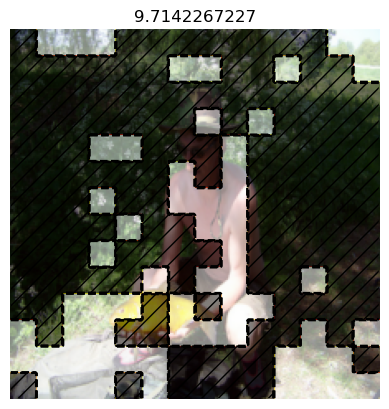

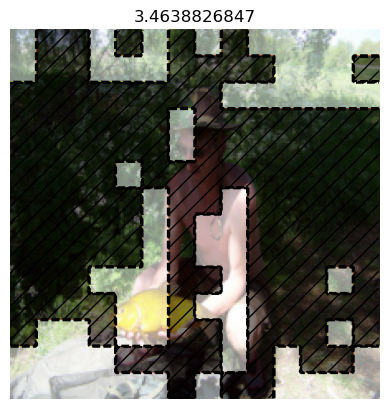

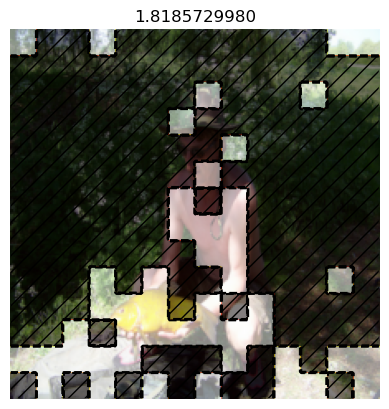

In [17]:
for m_i in range(len(masks)):
    mask = masks[m_i]
    mask_weight = mask_weights[m_i]
    plt.figure()
    plt.imshow(denormed_img[0].permute(1,2,0).cpu().numpy())
    plt.imshow(mask.cpu().numpy(), cmap='hot', alpha=0.5)
    # mask = (masks_sort_used[m_i] > 0).cpu().numpy()
    plt.contour(mask.cpu().numpy(), 2, colors='black', linestyles='dashed')
    plt.contourf(mask.cpu().numpy(), 2, hatches=['//', None, None],
                cmap='gray', extend='neither', linestyles='-', alpha=0.01)
    plt.axis('off')
    plt.title(f'{mask_weight.item():.10f}')
    plt.show()
    if m_i > 5:
        break

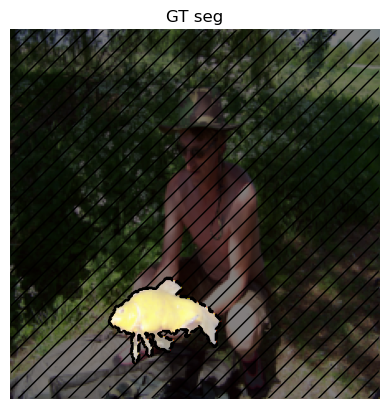

In [20]:
plt.figure()
plt.imshow(denormed_img[0].permute(1,2,0).cpu().numpy())
plt.imshow(segs[0][0].cpu().numpy(), cmap='hot', alpha=0.5)
# mask = (masks_sort_used[m_i] > 0).cpu().numpy()
plt.contour(segs[0][0].cpu().numpy(), 2, colors='black', linestyles='dashed')
plt.contourf(segs[0][0].cpu().numpy(), 2, hatches=['//', None, None],
            cmap='gray', extend='neither', linestyles='-', alpha=0.01)
plt.axis('off')
plt.title('GT seg')
plt.show()